In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import sys
sys.path.append('..')
sys.path.append('/home/idies/workspace/Storage/CarrieFilion/jhunt2021/')
from forsims_sciserver import SimHandler
import time
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import galactocentric_frame_defaults
_ = galactocentric_frame_defaults.set('pre-v4.0')
from astropy.convolution import convolve
from astropy.convolution.kernels import Gaussian2DKernel

In [21]:
from matplotlib import colors

In [2]:
#now to use the sims!
simM1 = SimHandler('M1') #initialize the sim handler classs
snap = simM1.loadwholesnap(702) #lets load time-step 702! this is after the dwarf galaxy has passed nearby
#this is also approximately our "present day" snapshot


start init at: 2022-07-20 17:38:44.641503
end at: 2022-07-20 17:38:44.644129


# recentering snap, selecting only -x values (avoid lugging around part of the galaxy we won't be using), flipping y, vy to get rotation sense correct

In [3]:
#recenterinngggg

#here, I make flags to select disk stars, bulge stars, and dwarf galaxy stars
disk_flag = (snap['mass']<200) #the mass of each disk star particle is 160.10631 Msun

disk_stars = simM1.apply_recen_snap(snap[(disk_flag)&(snap['x']<12)]) #recentering disk stars! trying
#to trim out some far aawy guys to let this actually run - down from 241 million to 158 million...
print('recentered!')

recentered!


In [4]:
#what if instead of formal downsampling, we just select the half/quarter of the galaxy we care about? e.g.
#get rid of stuff on X > 0 side of galaxy?
disk_stars = disk_stars[(disk_stars['x']<0)] #removing one half of galaxy 

In [5]:
del snap
print('bye snap')

bye snap


In [6]:
disk_stars['vy'] = -disk_stars['vy']
disk_stars['y'] = -disk_stars['y']
print('flipped y, vy')

flipped y, vy


# doing lots of coordinate transforms

In [7]:
#from our pal jo https://docs.galpy.org/en/v1.7.0/_modules/galpy/util/coords.html#rect_to_cyl_vec
phi = np.arctan2(disk_stars['y'],disk_stars['x'])
phi[phi<0] += 2*np.pi #between 0 and 2 pi, not -pi and pi 
phi_lh = np.pi - phi

v_phi = -disk_stars['vx']*np.sin(phi)+disk_stars['vy']*np.cos(phi)
v_phi_lh = -(-disk_stars['vx'])*np.sin(phi_lh)+disk_stars['vy']*np.cos(phi_lh)

R = np.sqrt(disk_stars['x']**2+disk_stars['y']**2+disk_stars['z']**2)
r = np.sqrt(disk_stars['x']**2+disk_stars['y']**2)

v_r = disk_stars['vx']*np.cos(phi) +disk_stars['vy']*np.sin(phi)
v_r_lh = (-disk_stars['vx'])*np.cos(phi_lh) +disk_stars['vy']*np.sin(phi_lh)

v_R = (r*v_r + disk_stars['z']*disk_stars['vz']) / R
v_R_lh = (r*v_r_lh + disk_stars['z']*disk_stars['vz']) / R

theta = np.arctan2(r, disk_stars['z'])

v_theta = (disk_stars['z'] * v_r - r*disk_stars['vz']) / R
v_theta_lh = (disk_stars['z'] * v_r_lh - r*disk_stars['vz']) / R

rsun = -8.3
dist = np.sqrt((disk_stars['x']-rsun)**2 + disk_stars['y']**2 + disk_stars['z']**2)


In [8]:
def vpec(l,b, U = 11.1, V = 12.24, W = 7.25): 
    #l, b in degrees, u, v, b in km/s
    l_rad = np.radians(l)
    b_rad = np.radians(b)
    #vpec = u*cos(l)*cos(b) + v*sin(l)*cos(b) + w*sin(b)
    v = U*np.cos(l_rad)*np.cos(b_rad) + V*np.sin(l_rad)*np.cos(b_rad) + W*np.sin(b_rad)
    return v


def beta(d, l, b, Rsun = 8.3):
    #d, Rsun in kpc! l, b in degrees!
    l_rad = np.radians(l)
    b_rad = np.radians(b) 
    #R^2 = Rsun^2 + d^2 cos^2(b) - 2 d Rsun cos(b) cos(l)
    R = np.sqrt(Rsun**2 + d**2 * np.cos(b_rad)**2 - 2 * d * Rsun * np.cos(b_rad)*np.cos(l_rad))
    beta = (Rsun/R) * np.cos(b_rad) * np.sin(l_rad)
    return beta


def alpha(d, l, b, Rsun = 8.3):
    #d, Rsun in kpc! l, b in degrees!
    l_rad = np.radians(l)
    b_rad = np.radians(b) 
    #r^2 = Rsun^2 + d^2 - 2 * d * Rsun * cos(b) * cos(l)
    r = np.sqrt(Rsun**2 + d**2 - 2 * d* Rsun * np.cos(b_rad) * np.cos(l_rad))
    #alpha = 1/r ( d - Rsun cos(b) cos (l))
    alpha = 1/r * (d - Rsun * np.cos(b_rad) * np.cos(l_rad))
    return alpha


def gamma(d, l, b, Rsun = 8.3):
    #d, Rsun in kpc! l, b in degrees!
    l_rad = np.radians(l)
    b_rad = np.radians(b) 
    #r^2 = Rsun^2 + d^2 - 2 * d * Rsun * cos(b) * cos(l)
    r = np.sqrt(Rsun**2 + d**2 - 2 * d* Rsun * np.cos(b_rad) * np.cos(l_rad))
    #R^2 = Rsun^2 + d^2 cos^2(b) - 2 d Rsun cos(b) cos(l)
    R = np.sqrt(Rsun**2 + d**2 * np.cos(b_rad)**2 - 2 * d * Rsun * np.cos(b_rad)*np.cos(l_rad))
    #gamma = sin(b) / (r * R) * (d * Rsun * cos(b) * cos(l) - Rsun^2)
    gamma = np.sin(b_rad)/(r * R) * (d * Rsun * np.cos(b_rad) * np.cos(l_rad) - Rsun**2)
    return gamma

def V_hel(alphas, betas, gammas, v_R_lh, v_phi_lh, v_theta_lh, l, b, Vlsr = 220):
    #take in alphas, gammas, betas, v_R, v_phi, v_theta (galactocentric spherical velocities)
    #l and b in degrees, vlsr (local standard of rest in km/s)
    #returns heliocentric velocity 
    #I get this from reverse engineering the kordopatis et al paper
    ########################## changed everything to the left handed version
    vhel = alphas*v_R_lh + betas*v_phi_lh + gammas*v_theta_lh - vpec(l,b) - \
                Vlsr*np.sin(np.radians(l))* np.cos(np.radians(b))
    return vhel

#vhelio = alpha*vRgal + beta*vPhigal + gamma*vthetagal - vpec(l,b) - Vlsr sin(l) cos(b)

In [9]:
#gotta convert stuff to l, b, etc - going to do it a million stars at a time to avoid issues - 
losv = np.array([])
sk_losv = np.array([])
l = np.array([])
b = np.array([])
dist = np.array([])
for i in range(112):
    min_indx = int(i * 1e6)
    max_indx = int((i+1) * 1e6)
    c = coord.SkyCoord(x=disk_stars['x'][min_indx:max_indx]*u.kpc, 
                       y=disk_stars['y'][min_indx:max_indx]*u.kpc, 
                       z=disk_stars['z'][min_indx:max_indx]*u.kpc,
                       v_x=disk_stars['vx'][min_indx:max_indx]*u.km/u.s,
                       v_y=disk_stars['vy'][min_indx:max_indx]*u.km/u.s,
                       v_z=disk_stars['vz'][min_indx:max_indx]*u.km/u.s,
                       frame='galactocentric',
                  representation_type='cartesian')
    trans = c.transform_to(coord.ICRS) #transform galactocentric cartesian to ICRS
    trans_gal = c.transform_to(coord.Galactic) #transform galactocentric cartesian to galactic (l, b)
    alphas = alpha(trans_gal.distance.value, trans_gal.l.value, trans_gal.b.value)
    betas = beta(trans_gal.distance.value, trans_gal.l.value, trans_gal.b.value)
    gammas = gamma(trans_gal.distance.value, trans_gal.l.value, trans_gal.b.value)
    helio_v = V_hel(alphas, betas, gammas, 
          v_R_lh[min_indx:max_indx], v_phi_lh[min_indx:max_indx], v_theta_lh[min_indx:max_indx], 
          trans_gal.l.value, trans_gal.b.value)

    losv = np.append(losv, helio_v)
    ###vphi = smallsnap[disk_flag]['vphi'] #no longer compute vphi when loading in snaps!
    #could get vphi w c.representation_type = 'cylindrical'
    l = np.append(l, trans_gal.l.value) #l in deg
    b = np.append(b, trans_gal.b.value) #b in deg
    dist = np.append(dist, trans_gal.distance.value)
    #now we have line-of-sight velocity, l, and b - can make hexbin colored by vlos/vphi
    skycoord_losv = trans.radial_velocity.value 
    sk_losv = np.append(sk_losv, skycoord_losv)

In [10]:
len(l) == len(disk_stars) #checking same # of stars as l, b coords

True

In [11]:
alphas = alpha(dist, l, b)
betas = beta(dist, l, b)
gammas = gamma(dist, l, b)

# selecting stars in ell = 90, 180 directions

In [18]:
width = 2
#height = 15
wedge_90 = (l<=90+width) & (l>=90-width) & (b>= 15) & (b <= 35) 
wedge_180 = (l<=180+width) & (l>=180-width)& (b>= 15) & (b <= 35)

print(len(disk_stars['y'][wedge_90]), 'field centered on l = 90','deg',
     'and height 15 <= b <= 35')
print(len(disk_stars['y'][wedge_180]), 'field centered on l = 180', 'deg',
     'and height 15 <= b <= 35')


13916 field centered on l = 90 deg and height 15 <= b <= 35
6113 field centered on l = 180 deg and height 15 <= b <= 35


In [19]:
width = 2
#height = 15
neg_wedge_90 = (l<=90+width) & (l>=90-width) & (b<= -15) & (b >= -35) 
neg_wedge_180 = (l<=180+width) & (l>=180-width)& (b<= -15) & (b >= -35)

print(len(disk_stars['y'][neg_wedge_90]), 'field centered on l = 90',
     'and height -35 <= b <= -15')
print(len(disk_stars['y'][neg_wedge_180]), 'field centered on l = 180', 
     'and height -35 <= b <= -15')

11836 field centered on l = 90 and height -35 <= b <= -15
10524 field centered on l = 180 and height -35 <= b <= -15


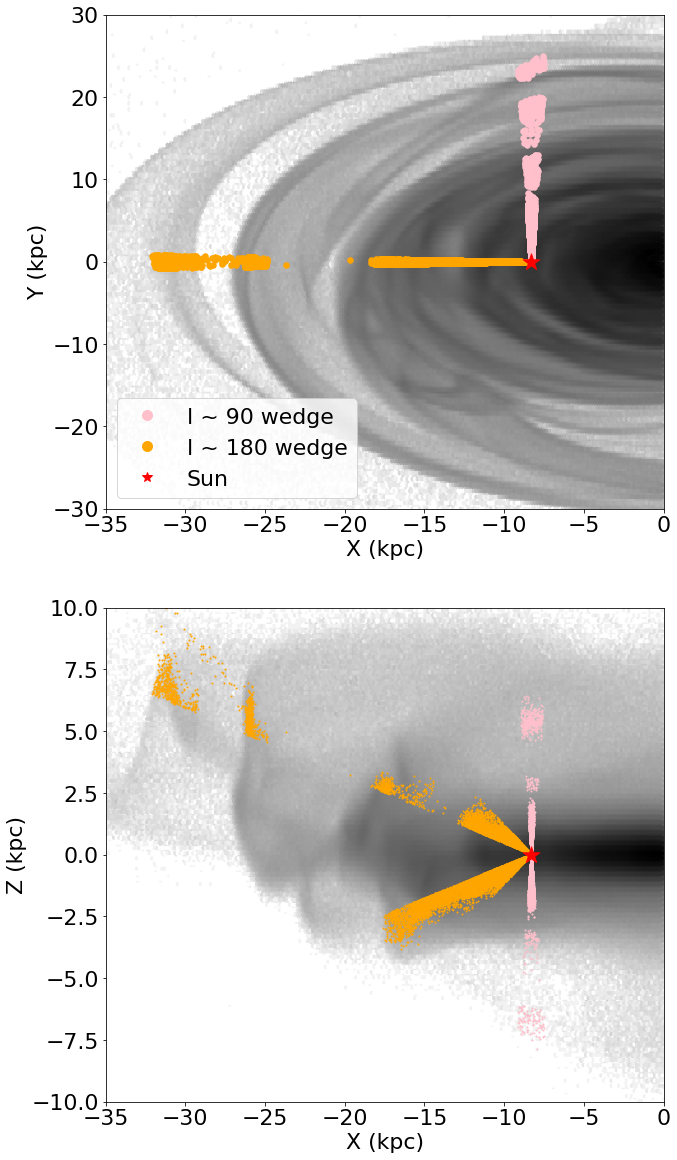

In [22]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,20))
#plt.scatter(disk_stars['x'],disk_stars['z'],c='k',s=.001)
ax1.hexbin(disk_stars['x'],disk_stars['y'],cmap='binary',gridsize=300, norm=colors.LogNorm())
ax1.scatter(disk_stars['x'][wedge_90],disk_stars['y'][wedge_90],c='pink',
           label='l ~ 90 wedge',s=30)
ax1.scatter(disk_stars['x'][neg_wedge_90],disk_stars['y'][neg_wedge_90],c='pink',
           label='l ~ 90 wedge',s=30)
ax1.scatter(disk_stars['x'][wedge_180],disk_stars['y'][wedge_180],c='orange',
           label='l ~ 180 wedge',s=30)
ax1.scatter(disk_stars['x'][neg_wedge_180],disk_stars['y'][neg_wedge_180],c='orange',
           label='l ~ 180 wedge',s=30)
ax1.scatter(-8.3,0,c='red',marker='*',s=300, label='Sun')
#plt.scatter(smallsnap[dwarf_flag]['x'],smallsnap[dwarf_flag]['y'],c='blue', label='Sag',s=1)
ax1.set_ylim(-30,30)
ax1.set_xlim(-35,0)
ax1.set_xlabel('X (kpc)')
ax1.set_ylabel('Y (kpc)')

from matplotlib.lines import Line2D
wedge90_leg = Line2D([0], [0], marker='o', markersize=np.sqrt(100), color='pink', linestyle='None')
wedge180_leg = Line2D([0], [0], marker='o', markersize=np.sqrt(100), color='orange', linestyle='None')
sun = Line2D([0], [0], marker='*', markersize=np.sqrt(100), color='red', linestyle='None')
ax1.legend([wedge90_leg, wedge180_leg, sun], ['l ~ 90 wedge', 'l ~ 180 wedge', 'Sun'],
          loc=3)

ax2.hexbin(disk_stars['x'],disk_stars['z'],cmap='binary',gridsize=300, norm=colors.LogNorm())
ax2.scatter(disk_stars['x'][wedge_90],disk_stars['z'][wedge_90],c='pink',
           label='l ~ 90 wedge',s=1)
ax2.scatter(disk_stars['x'][neg_wedge_90],disk_stars['z'][neg_wedge_90],c='pink',
           label='l ~ 90 wedge',s=1)
ax2.scatter(disk_stars['x'][wedge_180],disk_stars['z'][wedge_180],c='orange',
           label='l ~ 180 wedge',s=1)
ax2.scatter(disk_stars['x'][neg_wedge_180],disk_stars['z'][neg_wedge_180],c='orange',
           label='l ~ 180 wedge',s=1)
ax2.scatter(-8.3,0,c='red',marker='*',s=300, label='Sun')
#plt.scatter(smallsnap[dwarf_flag]['x'],smallsnap[dwarf_flag]['z'],c='blue', label='Sag',s=1)

ax2.set_ylim(-10,10)
ax2.set_xlim(-35,0)
ax2.set_xlabel('X (kpc)')
ax2.set_ylabel('Z (kpc)')
plt.savefig('top_down_edge_on.jpeg',bbox_inches = 'tight',
    pad_inches = 0)

665    14.696269
Name: helio_d, dtype: float64

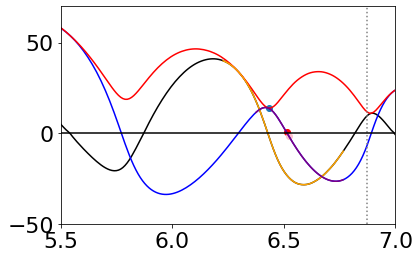

In [39]:
import pandas as pd
sag = pd.read_csv('S1-orbit.txt', header=None,sep='\s+',
                 names=['time','x','y','z','r','R','vx','vy','vz','bar_angle','pattern_speed'])

sag_coo = coord.SkyCoord(x=sag['x'].values*u.kpc, 
                       y= -sag['y'].values*u.kpc, #remember - flip y bc this is also in Jason's coords
                       z=sag['z'].values*u.kpc,
                       frame='galactocentric',
                  representation_type='cartesian')
sag_coo_gal = sag_coo.transform_to(coord.Galactic)
sag['helio_d'] = sag_coo_gal.distance.value

per = np.where(sag['R']==sag[(sag.time<=disk_stars['t'][0]-.1)&(sag.time>=disk_stars['t'][0]-.65)]['R'].min())[0]


last_zcross = np.where((-.75 <= sag['z'])&(sag['z']<=.75)&(sag.time<=disk_stars['t'][0]-.1)
                       &(sag.time>=disk_stars['t'][0]-.5))[0]


ll = np.where(sag['helio_d']==sag[(sag.time<=disk_stars['t'][0]-.1)&
                             (sag.time>=disk_stars['t'][0]-.65)]['helio_d'].min()) #closest passage to sun

x_last = sag.iloc[per]['x']
y_last = -sag.iloc[per]['y'] #remember, we flipped our y's
z_last = -sag.iloc[per]['z']
R_last = sag.iloc[per]['R']
r_last = sag.iloc[per]['r']

#plot

plt.plot(sag.time, sag.x,c='k')
plt.plot(sag.time, sag.z, c='b')
plt.plot(sag.time, sag.R, c='r')
plt.axvline(disk_stars['t'][0],c='grey',ls=':')
plt.plot(sag[(sag.time<=disk_stars['t'][0]-.1)&(sag.time>=disk_stars['t'][0]-.65)]['time'],
         sag[(sag.time<=disk_stars['t'][0]-.1)&(sag.time>=disk_stars['t'][0]-.65)]['x'],c='orange')
plt.plot(sag[(sag.time<=disk_stars['t'][0]-.1)&(sag.time>=disk_stars['t'][0]-.5)]['time'],
        sag[(sag.time<=disk_stars['t'][0]-.1)&(sag.time>=disk_stars['t'][0]-.5)]['z'],c='purple')
plt.xlim(5.5,7)
plt.ylim(-50,70)
plt.axhline(0,c='k')
plt.scatter(sag.iloc[per].time, sag.iloc[per].R)
plt.scatter(sag.iloc[last_zcross].time, sag.iloc[last_zcross].z,c='r')
plt.scatter(sag.iloc[last_zcross+1].time, sag.iloc[last_zcross+1].z,c='pink')

#rsun = -8.3
#dist = np.sqrt((disk_stars['x']-rsun)**2 + disk_stars['y']**2 + disk_stars['z']**2)
x_last.values[0], y_last.values[0], z_last.values[0], sag['helio_d'][per]
#np.sqrt((x_last.values[0]+8.3)**2+ y_last.values[0]**2+ (z_last.values[0]-.027)**2)
sag['helio_d'][last_zcross]


(665    6.512245
 Name: time, dtype: float64,
 665   -22.98255
 Name: x, dtype: float64,
 665    14.696269
 Name: helio_d, dtype: float64,
 665    0.382993
 Name: y, dtype: float64,
 <Longitude [181.4941035] deg>,
 <Latitude [1.78321498] deg>)

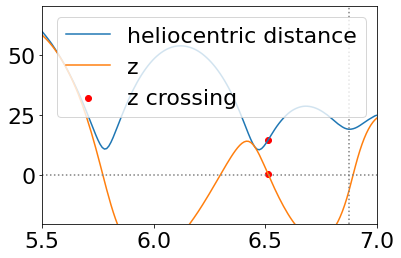

In [27]:
plt.plot(sag['time'],sag_coo_gal.distance.value, label='heliocentric distance')
plt.plot(sag.time, sag.z, label='z')
plt.scatter(sag.iloc[last_zcross].time, sag.iloc[last_zcross].z,c='r', label='z crossing')
plt.scatter(sag.iloc[last_zcross].time, sag.iloc[last_zcross].helio_d,c='r')
plt.axvline(disk_stars['t'][0],c='grey',ls=':')
plt.axhline(0,c='grey',ls=':')
plt.xlim(5.5,7)
plt.ylim(-20,70)
plt.legend()
sag.iloc[last_zcross].time, sag.iloc[last_zcross].x, sag.iloc[last_zcross].helio_d, \
    sag.iloc[last_zcross].y,sag_coo_gal[last_zcross].l,sag_coo_gal[last_zcross].b


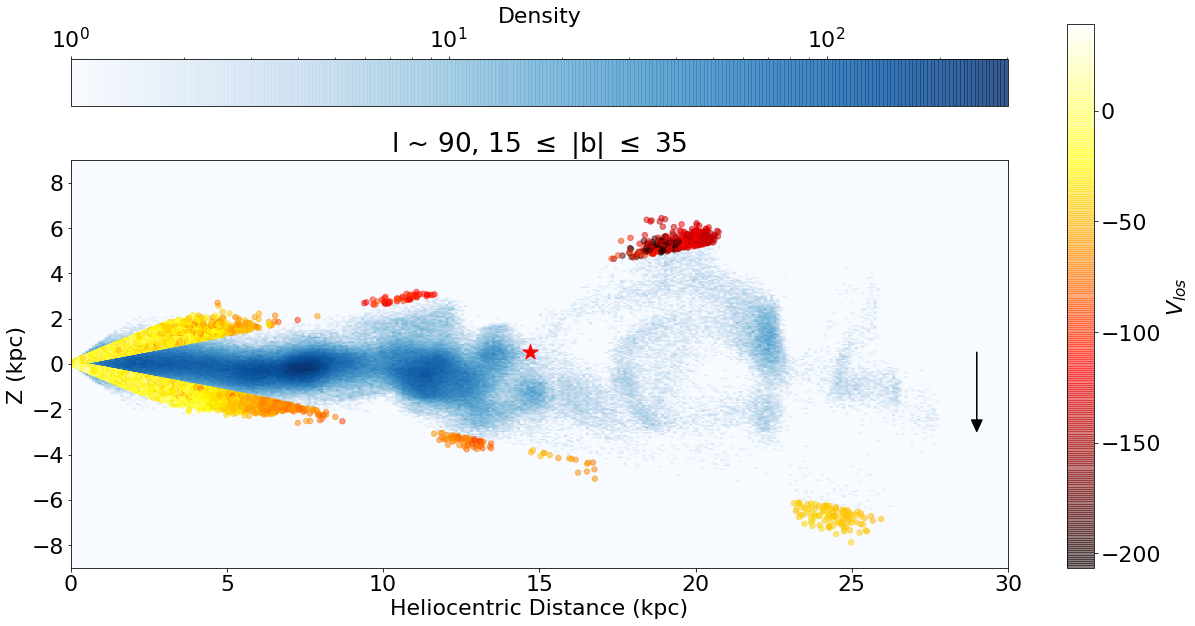

In [29]:
fig, (ax1) = plt.subplots(1,1,figsize=(21,10))
ax1.set_title(r'l ~ 90, 15 $\leq$ |b| $\leq$ 35')
cba = ax1.hexbin(dist[(dist<40)&(dist>0)&(l<=90+width)&(l>=90-width)], 
          disk_stars['z'][(dist<40)&(dist>0)&(l<=90+width)&(l>=90-width)],
             cmap='Blues',gridsize=[300,300], extent=[0,30, -9, 9],
                 norm=colors.LogNorm(), alpha=.8)
cb = ax1.scatter(dist[(dist<40)&(dist>0)&(l<=90+width)&(l>=90-width)&(abs(b)>=15)&(abs(b)<=35)], 
          disk_stars['z'][(dist<40)&(dist>0)&(l<=90+width)&(l>=90-width)&(abs(b)>=15)&(abs(b)<=35)],
          c = losv[(dist<40)&(dist>0)&(l<=90+width)&(l>=90-width)&(abs(b)>=15) &(abs(b)<=35)], alpha = .5,s=30,
                cmap='hot')
fig.colorbar(cb, ax=[ax1], label=r'$V_{los}$')
fig.colorbar(cba, ax=[ax1], location='top', label='Density',pad=0.1)
ax1.arrow(x=29, y=sag.iloc[last_zcross].z.values[0],
         dx=0, 
          dy = -3,
         head_width=.35,color='k')
ax1.scatter(sag.iloc[last_zcross].helio_d, sag.iloc[last_zcross].z, c='r',marker='*',s=250)

ax1.set_ylim(-9, 9)
ax1.set_xlim(0,30)
ax1.set_xlabel('Heliocentric Distance (kpc)')
ax1.set_ylabel('Z (kpc)')
plt.savefig('m1_losv_r_z_90_scatter_background_sag_direction_arrow_hot.jpeg',bbox_inches = 'tight',
    pad_inches = 0)

merger galaxy most recent disk crossing is at: 6.512245 time -22.98255 x 14.696269419566889 helio d and 0.5320615 in z


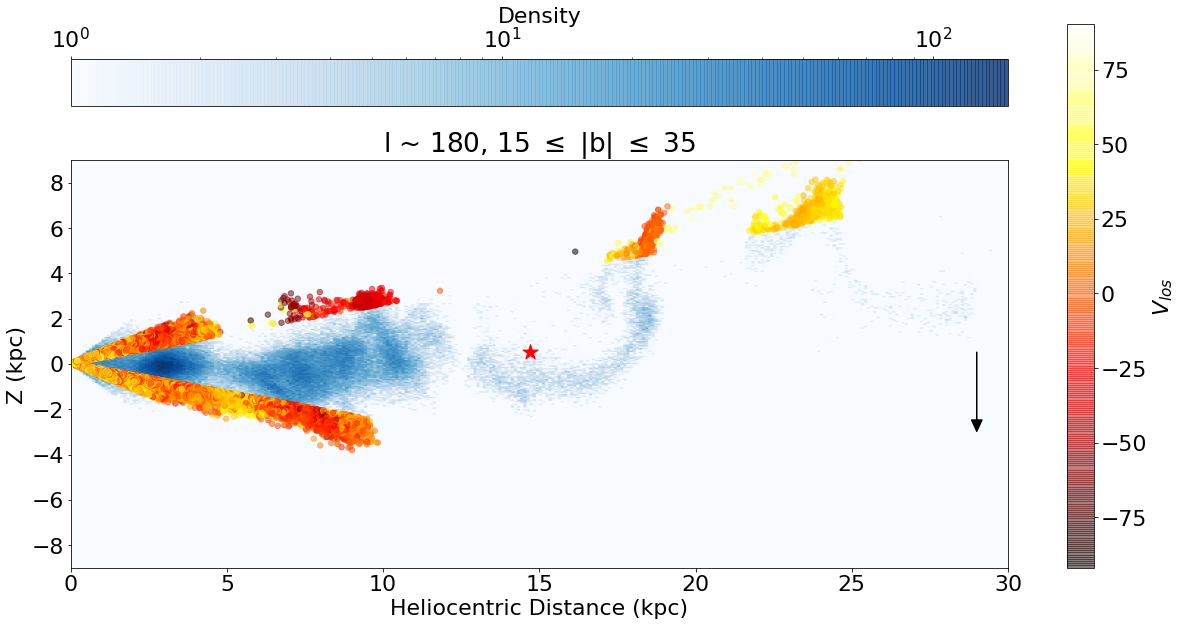

In [40]:
print('merger galaxy most recent disk crossing is at:',
     sag.iloc[last_zcross].time.values[0],'time',
      sag.iloc[last_zcross].x.values[0],'x',
    sag.iloc[last_zcross].helio_d.values[0],'helio d and', sag.iloc[last_zcross].z.values[0],'in z')
fig, (ax1) = plt.subplots(1,1,figsize=(21,10))
ax1.set_title(r'l ~ 180, 15 $\leq$ |b| $\leq$ 35')

cba = ax1.hexbin(dist[(dist<40)&(dist>0)&(l<=180+width)&(l>=180-width)], 
          disk_stars['z'][(dist<40)&(dist>0)&(l<=180+width)&(l>=180-width)],
             cmap='Blues',gridsize=[300,300], extent=[0,30, -9, 9], norm=colors.LogNorm(), alpha=.8)
cb = ax1.scatter(dist[(dist<40)&(dist>0)&(l<=180+width)&(l>=180-width)&(abs(b)>=15)&(abs(b)<=35)], 
          disk_stars['z'][(dist<40)&(dist>0)&(l<=180+width)&(l>=180-width)&(abs(b)>=15)&(abs(b)<=35)],
          c = losv[(dist<40)&(dist>0)&(l<=180+width)&(l>=180-width)&(abs(b)>=15) &(abs(b)<=35)], alpha = .5,s=30,
                cmap='hot')
fig.colorbar(cb, ax=[ax1], label=r'$V_{los}$')
fig.colorbar(cba, ax=[ax1], location='top', label='Density',pad=0.1)
ax1.arrow(x=29, y=sag.iloc[last_zcross].z.values[0],
         dx=0, 
          dy = -3,
         head_width=.35,color='k')
ax1.scatter(sag.iloc[last_zcross].helio_d, sag.iloc[last_zcross].z, c='r',marker='*',s=250)

ax1.set_ylim(-9, 9)
ax1.set_xlim(0,30)
ax1.set_xlabel('Heliocentric Distance (kpc)')
ax1.set_ylabel('Z (kpc)')
plt.savefig('m1_losv_r_z_180_scatter_background_sag_direction_arrow_blues_hot.jpeg',bbox_inches = 'tight',
    pad_inches = 0)

# possible breathing/bending mode plots...

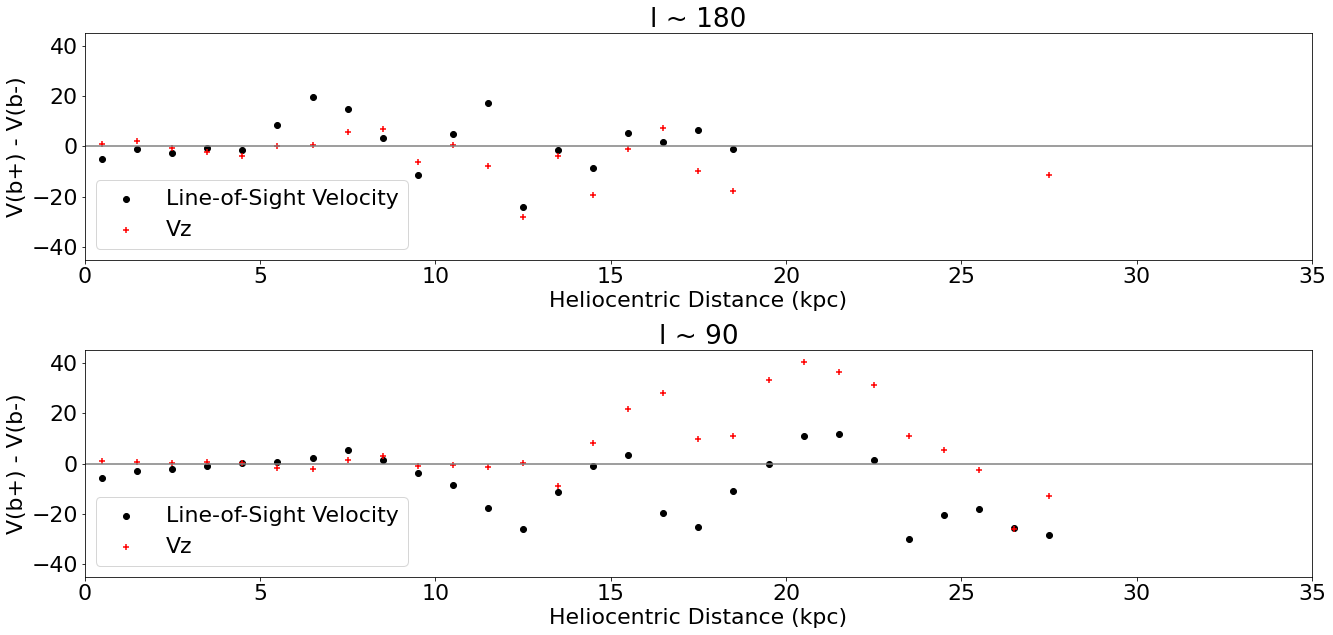

In [41]:
#Vdif = V_los (b+) - V_los (b-) at the same D, as a function of D
#vdif for Masashi :) 

#bin into 1 kpc bins in distance
from scipy import stats
distance_bins_180 = np.arange(0,35+1,1)
losv_180_bplus, dist_180_bplus_bin_edges, binnumber = stats.binned_statistic(dist[(dist<40)&(dist>0)&(b>0)&
                                                                                  (l<=180+width)&(l>=180-width)], 
                                                     losv[(dist<40)&(dist>0)&(b>0)&(l<=180+width)&(l>=180-width)], 
                                                                            'mean', bins=distance_bins_180)
losv_180_bmin, dist_180_bmin_bin_edges, binnumber = stats.binned_statistic(dist[(dist<40)&(dist>0)&(b<0)&
                                                                                  (l<=180+width)&(l>=180-width)], 
                                                     losv[(dist<40)&(dist>0)&(b<0)&(l<=180+width)&(l>=180-width)], 
                                                                            'mean', bins=distance_bins_180)

distance_bins_90 = np.arange(0,35+1,1)
losv_90_bplus, dist_90_bplus_bin_edges, binnumber = stats.binned_statistic(dist[(dist<40)&(dist>0)&(b>0)&
                                                                                  (l<=90+width)&(l>=90-width)], 
                                                     losv[(dist<40)&(dist>0)&(b>0)&(l<=90+width)&(l>=90-width)], 
                                                                            'mean', bins=distance_bins_90)
losv_90_bmin, dist_90_bmin_bin_edges, binnumber = stats.binned_statistic(dist[(dist<40)&(dist>0)&(b<0)&
                                                                                  (l<=90+width)&(l>=90-width)], 
                                                     losv[(dist<40)&(dist>0)&(b<0)&(l<=90+width)&(l>=90-width)], 
                                                                            'mean', bins=distance_bins_90)

########## Vz #############
distance_bins_180 = np.arange(0,35+1,1)
vz_180_bplus, dist_180_bplus_bin_edges, binnumber = stats.binned_statistic(dist[(dist<40)&(dist>0)&(b>0)&
                                                                                  (l<=180+width)&(l>=180-width)], 
                                          disk_stars['vz'][(dist<40)&(dist>0)&(b>0)&(l<=180+width)&(l>=180-width)], 
                                                                            'mean', bins=distance_bins_180)
vz_180_bmin, dist_180_bmin_bin_edges, binnumber = stats.binned_statistic(dist[(dist<40)&(dist>0)&(b<0)&
                                                                                  (l<=180+width)&(l>=180-width)], 
                                        disk_stars['vz'][(dist<40)&(dist>0)&(b<0)&(l<=180+width)&(l>=180-width)], 
                                                                            'mean', bins=distance_bins_180)

distance_bins_90 = np.arange(0,35+1,1)
vz_90_bplus, dist_90_bplus_bin_edges, binnumber = stats.binned_statistic(dist[(dist<40)&(dist>0)&(b>0)&
                                                                                  (l<=90+width)&(l>=90-width)], 
                                            disk_stars['vz'][(dist<40)&(dist>0)&(b>0)&(l<=90+width)&(l>=90-width)], 
                                                                            'mean', bins=distance_bins_90)
vz_90_bmin, dist_90_bmin_bin_edges, binnumber = stats.binned_statistic(dist[(dist<40)&(dist>0)&(b<0)&
                                                                                  (l<=90+width)&(l>=90-width)], 
                                            disk_stars['vz'][(dist<40)&(dist>0)&(b<0)&(l<=90+width)&(l>=90-width)], 
                                                                            'mean', bins=distance_bins_90)

dist_bin_width = .5
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(22,10))
ax1.set_title('l ~ 180')
ax1.scatter(dist_180_bmin_bin_edges[:-1]+dist_bin_width, losv_180_bplus-losv_180_bmin, c='k', 
           label='Line-of-Sight Velocity')
ax1.scatter(dist_180_bmin_bin_edges[:-1]+dist_bin_width, vz_180_bplus-vz_180_bmin, c='r',marker='+',
           label='Vz')
ax1.axhline(0,c='grey')
ax1.set_xlim(0,35)
ax1.set_ylim(-45, 45)
ax1.legend(loc=3)
ax1.set_xlabel('Heliocentric Distance (kpc)')
ax1.set_ylabel('V(b+) - V(b-)')

ax2.set_title('l ~ 90')
ax2.scatter(dist_90_bmin_bin_edges[:-1]+dist_bin_width, losv_90_bplus-losv_90_bmin, c='k', 
            label='Line-of-Sight Velocity')
ax2.scatter(dist_90_bmin_bin_edges[:-1]+dist_bin_width, vz_90_bplus-vz_90_bmin, c='r', marker='+',
            label='Vz')
ax2.axhline(0,c='grey')
ax2.set_xlim(0,35) 
ax2.set_ylim(-45, 45)
ax2.set_xlabel('Heliocentric Distance (kpc)')
ax2.set_ylabel('V(b+) - V(b-)')
ax2.legend(loc=3)
plt.subplots_adjust(hspace=.4)
plt.savefig('dist_vdif.jpeg',bbox_inches = 'tight',
    pad_inches = 0)

Text(0, 0.5, 'Z (kpc)')

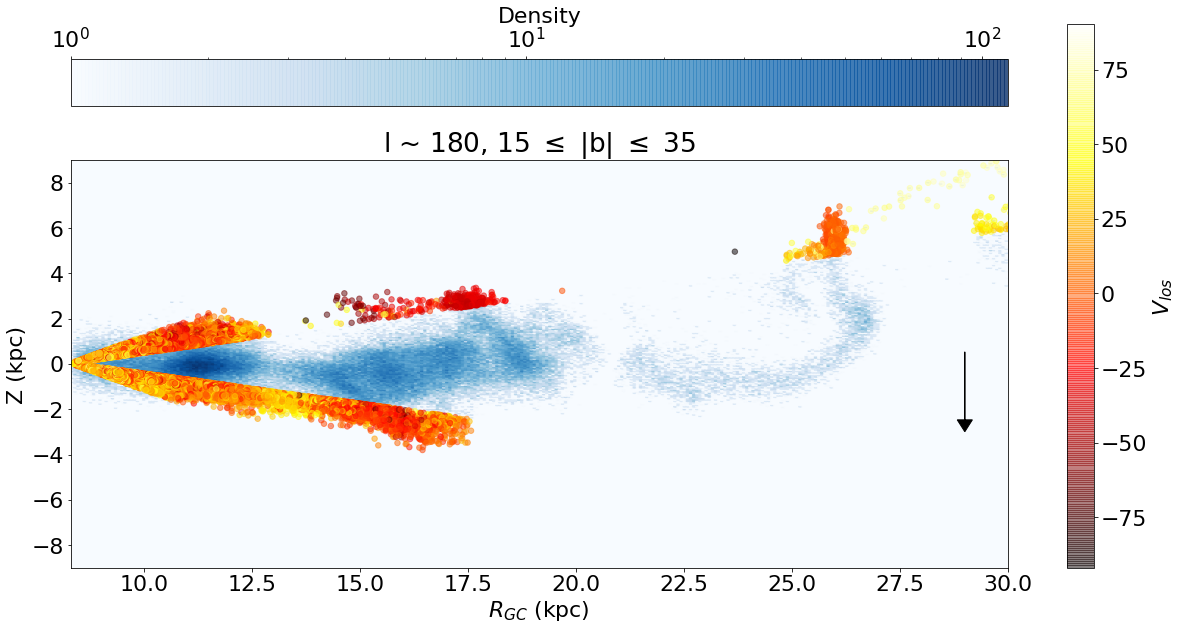

In [36]:
fig, (ax1) = plt.subplots(1,1,figsize=(21,10))
ax1.set_title(r'l ~ 180, 15 $\leq$ |b| $\leq$ 35')
cba = ax1.hexbin(r[(dist<40)&(dist>0)&(l<=180+width)&(l>=180-width)], 
          disk_stars['z'][(dist<40)&(dist>0)&(l<=180+width)&(l>=180-width)],
             cmap='Blues',gridsize=[300,300], extent=[8.3,30, -9, 9],
                 norm=colors.LogNorm(), alpha=.8)
cb = ax1.scatter(r[(dist<40)&(dist>0)&(l<=180+width)&(l>=180-width)&(abs(b)>=15)&(abs(b)<=35)], 
          disk_stars['z'][(dist<40)&(dist>0)&(l<=180+width)&(l>=180-width)&(abs(b)>=15)&(abs(b)<=35)],
          c = losv[(dist<40)&(dist>0)&(l<=180+width)&(l>=180-width)&(abs(b)>=15) &(abs(b)<=35)], alpha = .5,s=30,
                cmap='hot')
fig.colorbar(cb, ax=[ax1], label=r'$V_{los}$')
fig.colorbar(cba, ax=[ax1], location='top', label='Density',pad=0.1)
ax1.arrow(x=29, y=sag.iloc[last_zcross].z.values[0], dx=0, 
          dy = -3,head_width=.35,color='k')

ax1.set_ylim(-9, 9)
ax1.set_xlim(8.3,30)
ax1.set_xlabel('$R_{GC}$ (kpc)')
ax1.set_ylabel('Z (kpc)')
#plt.savefig('m1_losv_r_z_180_scatter_background_sag_direction_arrow_extent_blues_hot.jpeg',bbox_inches = 'tight',
#    pad_inches = 0)